# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [3]:
poly_a1 = 5.0
# poly_a1 = -10.0 # 5.0
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + (poly_a1)*X + 15 
def func_4(X): # Sine wave~
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2 + 50.0*np.sin(X)

In [4]:
func_dict = dict()
func_dict["f1"] = func_0
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3
# func_dict["f2"] = func_4

# Average line
func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )

In [5]:
def draw_normal_func(func_dict):
    draw_func(func_dict["f1"], mark='c:', label="f1")
    draw_func(func_dict["f2"], mark='g:', label="f2")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))

# Input
is_gapped = True
# is_gapped = False
#
if not is_gapped:
    X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again
else:
    X_data = np.concatenate( (np.linspace(-5.0, -2.0, m//2), np.linspace(2.0, 5.0, m-m//2)) )
    X_data = X_data.reshape((m,1))
    np.random.shuffle(X_data)

# Output
is_multiout = True
# is_multiout = False
if is_multiout:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
else:        
    y_data_pure = func_dict["f_avg"](X_data)

# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
# Method 1: simply slice
# X_train = X_data[:m_train]
# y_train = y_data[:m_train]
# X_valid = X_data[m_train:]
# y_valid = y_data[m_train:]

# Method 2: shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)

(80, 1)


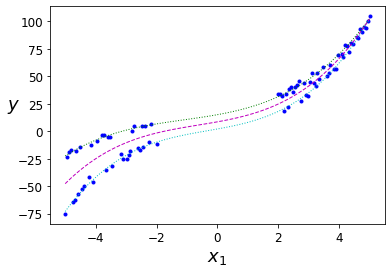

In [9]:
plt.plot(X_train, y_train, "b.")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [10]:
prediction_error_dict = dict()

def get_prediction_error(func_in, func_dict, name="", x_min=-5, x_max=5, prediction_error_dict=prediction_error_dict):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func).reshape((n_sample,1))
    y_gt = func_dict["f_avg"](X_func).reshape((n_sample,1))
    print("y_func.shape = %s" % str(y_func.shape))
    print("y_gt.shape = %s" % str(y_gt.shape))
#     total_error = np.sqrt(np.square(y_func - y_gt).mean())
    total_error = np.abs(y_func - y_gt).mean()
    prediction_error_dict[name] = total_error
    return total_error

def print_all_prediction_error(prediction_error_dict=prediction_error_dict):
    for _n in prediction_error_dict:
        print("%s: %f" % (_n, prediction_error_dict[_n]))

# Simple FCs (number --> number)

Build the regression model

In [11]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mean_absolute_error", optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 2s 366ms/step - loss: 2501.0579 - val_loss: 1699.7252
Epoch 2/100
3/3 [==============================] - 0s 103ms/step - loss: 2392.7747 - val_loss: 1599.5090
Epoch 3/100
3/3 [==============================] - 0s 72ms/step - loss: 2195.6704 - val_loss: 1402.1895
Epoch 4/100
3/3 [==============================] - 0s 100ms/step - loss: 1752.8162 - val_loss: 961.3848
Epoch 5/100
3/3 [==============================] - 0s 73ms/step - loss: 861.1442 - val_loss: 624.3866
Epoch 6/100
3/3 [==============================] - 0s 65ms/step - loss: 728.7890 - val_loss: 997.2039
Epoch 7/100
3/3 [==============================] - 0s 64ms/step - loss: 848.1270 - val_loss: 545.8126
Epoch 8/100
3/3 [==============================] - 0s 109ms/step - loss: 578.0746 - val_loss: 664.8073
Epoch 9/100
3/3 [==============================] - 0s 81ms/step - loss: 699.0856 - val_loss: 474.8560
Epoch 10/100
3/3 [==============================] - 0s 111ms/step - los

3/3 [==============================] - 0s 89ms/step - loss: 168.1313 - val_loss: 151.2780
Epoch 80/100
3/3 [==============================] - 0s 82ms/step - loss: 166.5618 - val_loss: 148.8405
Epoch 81/100
3/3 [==============================] - ETA: 0s - loss: 152.158 - 0s 87ms/step - loss: 167.4018 - val_loss: 150.1952
Epoch 82/100
3/3 [==============================] - 0s 99ms/step - loss: 167.7217 - val_loss: 156.4067
Epoch 83/100
3/3 [==============================] - 0s 91ms/step - loss: 163.8559 - val_loss: 159.0480
Epoch 84/100
3/3 [==============================] - 0s 110ms/step - loss: 167.9133 - val_loss: 154.8289
Epoch 85/100
3/3 [==============================] - ETA: 0s - loss: 157.052 - 0s 88ms/step - loss: 164.0181 - val_loss: 150.9023
Epoch 86/100
3/3 [==============================] - 0s 107ms/step - loss: 167.5747 - val_loss: 153.2783
Epoch 87/100
3/3 [==============================] - 0s 107ms/step - loss: 165.3836 - val_loss: 154.4326
Epoch 88/100
3/3 [=============

Plot the result

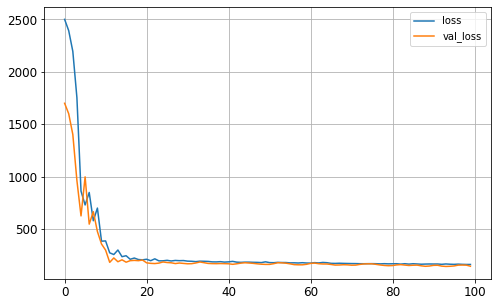

In [13]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

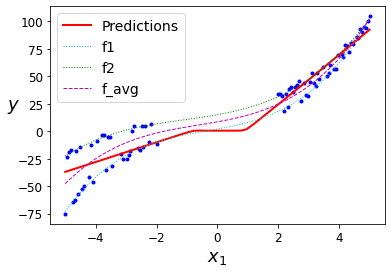

In [14]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [15]:
get_prediction_error(model.predict, func_dict, name="num-num")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


6.127837753502251

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [16]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [17]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mean_absolute_error", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 2769.3936X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 263ms/step - loss: 2465.9836 - val_loss: 1677.4486
Epoch 2/100
3/3 [==============================] - 0s 75ms/step - loss: 2337.4468 - val_loss: 1557.4973
Epoch 3/100
3/3 [==============================] - 0s 55ms/step - loss: 1990.9935 - val_loss: 1318.9270
Epoch 4/100
3/3 [==============================] - 0s 74ms/step - loss: 1308.8440 - val_loss: 1095.9314
Epoch 5/100
3/3 [==============================] - 0s 54ms/step - loss: 825.5835 - val_loss: 594.5280
Epoch 6/100
3/3 [==============================] - 0s 66ms/step - loss: 550.0242 - val_loss: 380.0797
Epoch 7/100
3/3 [==============================] - 0s 101ms/step - loss: 339.6585 - val_loss: 274.7464
Epoch 8/100
3/3 [==============================] - 0s 77ms/step -

Epoch 78/100
3/3 [==============================] - 0s 69ms/step - loss: 155.7006 - val_loss: 111.8290
Epoch 79/100
3/3 [==============================] - 0s 65ms/step - loss: 155.3499 - val_loss: 114.6261
Epoch 80/100
3/3 [==============================] - 0s 68ms/step - loss: 155.6967 - val_loss: 117.3030
Epoch 81/100
3/3 [==============================] - 0s 60ms/step - loss: 154.2690 - val_loss: 108.0254
Epoch 82/100
3/3 [==============================] - 0s 55ms/step - loss: 155.8917 - val_loss: 102.9313
Epoch 83/100
3/3 [==============================] - 0s 60ms/step - loss: 154.2392 - val_loss: 107.0775
Epoch 84/100
3/3 [==============================] - 0s 109ms/step - loss: 154.2556 - val_loss: 120.2179
Epoch 85/100
3/3 [==============================] - 0s 83ms/step - loss: 156.9181 - val_loss: 121.6326
Epoch 86/100
3/3 [==============================] - 0s 105ms/step - loss: 153.3307 - val_loss: 107.9431
Epoch 87/100
3/3 [==============================] - 0s 94ms/step - loss

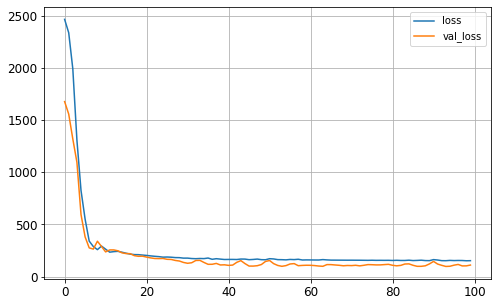

In [19]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


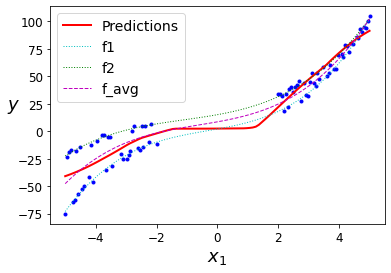

In [20]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [21]:
get_prediction_error(model.predict, func_dict, name="grid-num")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


4.337163884602609

# Grid & Regression by Classification (grid --> grid)

In [22]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num
    
    def get_statistic(self, grid):
        grid_sum = np.sum(grid, axis=-1)
        _mean = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        _var  = np.sum( ((self.x_grid.reshape((1,-1)) - _mean.reshape((-1,1)))**2 * grid), axis=-1) / grid_sum # element-wise
        # print("(_mean, _var) = (%f, %f)" % (_mean, _var))
        _stddev = np.sqrt(_var)
        return _mean, _stddev

In [23]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) # 20.0
# class_num = 20
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=15.0) # 20.0
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=6.0) # 5.0 

self.x_grid = [-100.          -95.91836735  -91.83673469  -87.75510204  -83.67346939
  -79.59183673  -75.51020408  -71.42857143  -67.34693878  -63.26530612
  -59.18367347  -55.10204082  -51.02040816  -46.93877551  -42.85714286
  -38.7755102   -34.69387755  -30.6122449   -26.53061224  -22.44897959
  -18.36734694  -14.28571429  -10.20408163   -6.12244898   -2.04081633
    2.04081633    6.12244898   10.20408163   14.28571429   18.36734694
   22.44897959   26.53061224   30.6122449    34.69387755   38.7755102
   42.85714286   46.93877551   51.02040816   55.10204082   59.18367347
   63.26530612   67.34693878   71.42857143   75.51020408   79.59183673
   83.67346939   87.75510204   91.83673469   95.91836735  100.        ]


In [24]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2g.convert([[-1.2]])
print(grid_1)

[[3.57995092e-60 2.08100846e-55 7.61538914e-51 1.75441300e-46
  2.54444491e-42 2.32314196e-38 1.33530332e-34 4.83176258e-31
  1.10065884e-27 1.57841554e-24 1.42498879e-21 8.09884396e-19
  2.89771784e-16 6.52695532e-14 9.25521826e-12 8.26198061e-10
  4.64304784e-08 1.64264466e-06 3.65852120e-05 5.12966502e-04
  4.52786966e-03 2.51605603e-02 8.80173281e-02 1.93837381e-01
  2.68737559e-01 2.34552834e-01 1.28876722e-01 4.45789421e-02
  9.70748025e-03 1.33077537e-03 1.14848275e-04 6.23972825e-06
  2.13416679e-07 4.59528573e-09 6.22899760e-11 5.31551427e-13
  2.85557712e-15 9.65748361e-18 2.05615356e-20 2.75593262e-23
  2.32542921e-26 1.23526215e-29 4.13082337e-33 8.69632169e-37
  1.15254011e-40 9.61607812e-45 5.05081425e-49 1.67011468e-53
  3.47658354e-58 4.55596654e-63]]


In [25]:
n2g.inv_convert(grid_1)

array([-1.2])

In [26]:
n2g.get_statistic(grid_1)

(array([-1.2]), array([6.]))

### Convert the labels to grid (pre-processing)

In [27]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [28]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

(80, 50)
(20, 50)


In [29]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [30]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 3.9474X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 228ms/step - loss: 3.9439 - val_loss: 3.9042
Epoch 2/100
3/3 [==============================] - 0s 89ms/step - loss: 3.9019 - val_loss: 3.8711
Epoch 3/100
3/3 [==============================] - 0s 43ms/step - loss: 3.8403 - val_loss: 3.8430
Epoch 4/100
3/3 [==============================] - 0s 113ms/step - loss: 3.7846 - val_loss: 3.8059
Epoch 5/100
3/3 [==============================] - 0s 76ms/step - loss: 3.7150 - val_loss: 3.7568
Epoch 6/100
3/3 [==============================] - 0s 103ms/step - loss: 3.6303 - val_loss: 3.7008
Epoch 7/100
3/3 [==============================] - 0s 97ms/step - loss: 3.5247 - val_loss: 3.6474
Epoch 8/100
3/3 [==============================] - 0s 89ms/step - loss: 3.4174 - val_loss: 3.5854
Epoch

3/3 [==============================] - 0s 82ms/step - loss: 2.4101 - val_loss: 2.5910
Epoch 82/100
3/3 [==============================] - 0s 88ms/step - loss: 2.4098 - val_loss: 2.5724
Epoch 83/100
3/3 [==============================] - 0s 87ms/step - loss: 2.4070 - val_loss: 2.5549
Epoch 84/100
3/3 [==============================] - 0s 90ms/step - loss: 2.4257 - val_loss: 2.5271
Epoch 85/100
3/3 [==============================] - 0s 96ms/step - loss: 2.4166 - val_loss: 2.5341
Epoch 86/100
3/3 [==============================] - 0s 83ms/step - loss: 2.4087 - val_loss: 2.6002
Epoch 87/100
3/3 [==============================] - 0s 93ms/step - loss: 2.4069 - val_loss: 2.6400
Epoch 88/100
3/3 [==============================] - 0s 82ms/step - loss: 2.3968 - val_loss: 2.6066
Epoch 89/100
3/3 [==============================] - 0s 102ms/step - loss: 2.3945 - val_loss: 2.5457
Epoch 90/100
3/3 [==============================] - 0s 80ms/step - loss: 2.4132 - val_loss: 2.5176
Epoch 91/100
3/3 [====

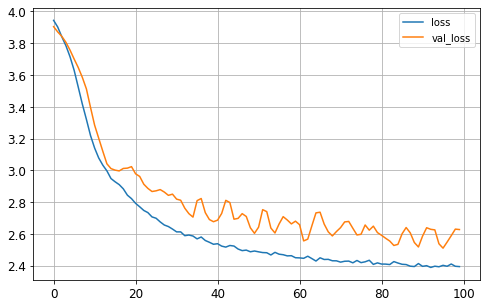

In [31]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


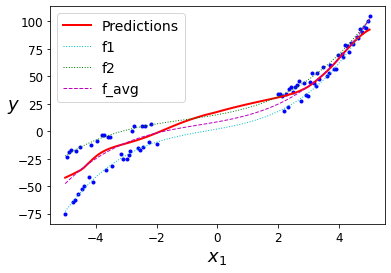

In [32]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [33]:
get_prediction_error((lambda X: n2g.inv_convert(model.predict(X)) ), func_dict, name="grid-rbc")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


3.8608903114497877

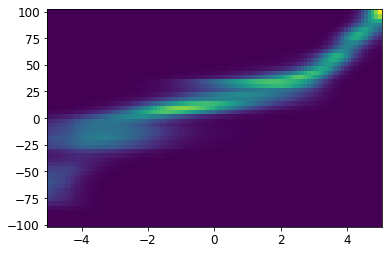

In [34]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")

### Draw the 1-sigma boundary line

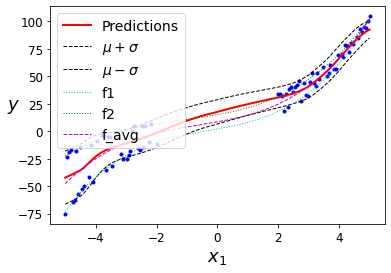

In [35]:
def n_sigma_boundary_line(X, n):
    _mean, _sigma = n2g.get_statistic(model.predict(X))
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification + Offset Estimation (grid --> grid,num)

In [36]:
class num2gridOffset_np():
    def __init__(self, units, x_min=-10, x_max=10):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        # bins
        x_space = np.average(self.x_grid[1:] - self.x_grid[:-1])
        print("x_space = %f" % x_space)
        x_0 = self.x_grid[0] - 0.5 * x_space
        self.x_bins = [x_0 + _i*x_space for _i in range(len(self.x_grid)+1)]
        print("self.x_grid = %s" % str(self.x_grid))
#         print("self.x_bins = %s" % str(self.x_bins))
        
    def convert(self, X):
        '''
        Convert a batch of number to one-hot class and numerical offset to each grid's center
        (m, 1) --> (m, n_units, 2)
        '''
        X = np.array(X)
        if len(X.shape) <= 1:
            X = X.reshape((-1,1))
        idxs_bin = np.digitize(X, self.x_bins, right=False) 
        idxs_grid = (idxs_bin - 1) + 1*(idxs_bin<= 0) - 1*(idxs_bin>=self.units)
        print(idxs_grid.shape)
        #
        batch_size = X.shape[0]
        grid = np.zeros((batch_size, self.units, 2))
        # Fill in the values
        grid[np.arange(batch_size), idxs_grid.reshape((-1,)), 0] = 1.0
        grid[np.arange(batch_size), :, 1] = X - self.x_grid.reshape((1,-1)) # Offset
        return grid
    
    def inv_convert(self, grid):
        idxs_grid = np.argmax(grid[...,0], axis=1)
        print(idxs_grid.shape)
        #
        batch_size = grid.shape[0]
        offset_est = grid[np.arange(batch_size),idxs_grid,1]
        print(offset_est.shape)
        num_est = self.x_grid[idxs_grid].reshape((1,-1)) + offset_est
        return num_est.reshape((-1,))

In [37]:
class_num = 10 # 10
n2go = num2gridOffset_np(class_num, x_min=-100.0, x_max=100.0) 

x_space = 22.222222
self.x_grid = [-100.          -77.77777778  -55.55555556  -33.33333333  -11.11111111
   11.11111111   33.33333333   55.55555556   77.77777778  100.        ]


In [38]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2go.convert([[-1.2], [50.5]])
print(grid_1)

(2, 1)
[[[   0.           98.8       ]
  [   0.           76.57777778]
  [   0.           54.35555556]
  [   0.           32.13333333]
  [   1.            9.91111111]
  [   0.          -12.31111111]
  [   0.          -34.53333333]
  [   0.          -56.75555556]
  [   0.          -78.97777778]
  [   0.         -101.2       ]]

 [[   0.          150.5       ]
  [   0.          128.27777778]
  [   0.          106.05555556]
  [   0.           83.83333333]
  [   0.           61.61111111]
  [   0.           39.38888889]
  [   0.           17.16666667]
  [   1.           -5.05555556]
  [   0.          -27.27777778]
  [   0.          -49.5       ]]]


In [39]:
n2go.inv_convert(grid_1)

(2,)
(2,)


array([-1.2, 50.5])

### Convert the labels to grid (pre-processing)

In [40]:
y_train_grid_offset = n2go.convert(y_train)
y_valid_grid_offset = n2go.convert(y_valid)

(80, 1)
(20, 1)


In [41]:
print(y_train_grid_offset.shape)
print(y_valid_grid_offset.shape)

(80, 10, 2)
(20, 10, 2)


In [42]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="selu")(z)
# Outputs
z_proba = keras.layers.Dense(30, activation="relu")(z)
z_proba  = keras.layers.Dense(class_num, activation="softmax")(z_proba)
z_offset = keras.layers.Dense(class_num, activation="relu")(z)
z_offset = keras.layers.Dense(class_num)(z_offset)
# Concatenate
z_proba  = keras.layers.Reshape([class_num,1])(z_proba)
z_offset = keras.layers.Reshape([class_num,1])(z_offset)
out_cat = keras.layers.Concatenate(axis=-1)([z_proba, z_offset])
#
# Models for trainig and real usage
model = keras.Model(inputs=[inputs], outputs=[out_cat])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [43]:
# Customized loss function

cce = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
# cce(y_true, y_pred).numpy()

def centerLoss_fn(y_true, y_pred):
    #
    y_true_proba = y_true[...,0]
    y_true_value = y_true[...,1]
    #
    y_pred_proba = y_pred[...,0]
    y_pred_value = y_pred[...,1]
    
    #
    cce_loss = cce(y_true_proba, y_pred_proba) / class_num
    #
    y_true_value_est = tf.reduce_sum((y_true_proba * y_true_value), axis=-1)
    y_pred_value_est = tf.reduce_sum((y_true_proba * y_pred_value), axis=-1)
#     y_pred_value_est = tf.reduce_sum((y_pred_proba * y_pred_value), axis=-1)
    value_loss = tf.abs(y_pred_value_est - y_true_value_est)
    
    # Total loss
#     return (0.5*cce_loss + 0.5*value_loss )
    return (0.2*cce_loss + 0.8*value_loss )
#     return (cce_loss)
#     return (value_loss )

In [44]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.05)
model.compile(loss=centerLoss_fn, optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [45]:
# history = model.fit(X_train, y_train_grid_offset, epochs=100,
#                     validation_data=(X_valid, y_valid_grid_offset))

In [46]:
# import pandas as pd

# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# # plt.gca().set_ylim(0, 1)
# plt.show()

In [47]:
# plt.plot(X_train, y_train, "b.")
# draw_func((lambda X: n2go.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# plt.show()

In [48]:
# get_prediction_error((lambda X: n2go.inv_convert(model.predict(X)) ), func_dict, name="grid-classOffset")

# Parametric Uncertainty/Distribution Estimation

In this section, we try to estimate uncertainty (actually, fit the dataset distribution) with parametric reprecentation of a distribution instead of a discretized non-parametric representation.

Possible solution includes
- Quantile estimation with pinball loss (statistic)
- Guassian distribution (fit a prabability distribution)

## Quantile Estimation with Pinball Loss (grid --> parameters)

Quantile estimation and pinball loss is based on the concept of statistic, which predict the value based on the rank of samples in the dataset.

The outputs of the model are $(y_{10}, y_{90})$, 10% quantile prediction and 90% quantile prediction, respectively.

In [49]:
# quantile_list = [0.5]
# quantile_list = [0.9]
quantile_list = [0.1, 0.9]
# quantile_list = [0.05, 0.95]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_quantile = len(quantile_list)

In [50]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l1(0.01)),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(num_quantile) # (y10, y90)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [51]:
# Customized loss function
def pinballLoss_fn(y_true, y_pred, tau):
    # tau: quantile, tau in [0.0, 1.0]
    # y_true: label mean
    # y_pred: predicted tau quantile
    _q = y_true - y_pred
    return tf.math.maximum( (tau*_q), ((tau-1.0)*_q))
    
def pinballLoss_10_90_fn(y_true, y_pred):
    #
    return pinballLoss_fn(y_true, y_pred[:,0:1], 0.1) + pinballLoss_fn(y_true, y_pred[:,1:2], 0.9)

def pinballLoss_full_fn(y_true, y_pred):
    #
    pinball_losses = tf.stack( [pinballLoss_fn(y_true, y_pred[:, _i:(_i+1)], _tau) for _i, _tau in enumerate(quantile_list)], axis=1)
    return tf.reduce_sum(pinball_losses, axis=1)

In [52]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
# model.compile(loss=pinballLoss_10_90_fn, optimizer=optimizer)
model.compile(loss=pinballLoss_full_fn, optimizer=optimizer)

In [53]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 42.3113X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 251ms/step - loss: 41.3773 - val_loss: 31.8420
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 39.59 - 0s 86ms/step - loss: 37.9439 - val_loss: 27.2072
Epoch 3/100
3/3 [==============================] - 0s 90ms/step - loss: 32.0467 - val_loss: 20.9141
Epoch 4/100
3/3 [==============================] - 0s 62ms/step - loss: 25.4330 - val_loss: 14.9279
Epoch 5/100
3/3 [==============================] - 0s 127ms/step - loss: 18.7075 - val_loss: 12.1568
Epoch 6/100
3/3 [==============================] - 0s 109ms/step - loss: 15.4415 - val_loss: 13.3659
Epoch 7/100
3/3 [==============================] - 0s 93ms/step - loss: 14.6494 - val_loss: 14.4913
Epoch 8/100
3/3 [==============================] - 0s 93ms/step 

3/3 [==============================] - 0s 113ms/step - loss: 2.6892 - val_loss: 2.7703
Epoch 81/100
3/3 [==============================] - 0s 110ms/step - loss: 2.9003 - val_loss: 3.1668
Epoch 82/100
3/3 [==============================] - 0s 77ms/step - loss: 2.9263 - val_loss: 2.9998
Epoch 83/100
3/3 [==============================] - 0s 71ms/step - loss: 2.7133 - val_loss: 2.5683
Epoch 84/100
3/3 [==============================] - 0s 63ms/step - loss: 2.7620 - val_loss: 2.4941
Epoch 85/100
3/3 [==============================] - 0s 57ms/step - loss: 2.5982 - val_loss: 2.9275
Epoch 86/100
3/3 [==============================] - 0s 58ms/step - loss: 2.7501 - val_loss: 2.7302
Epoch 87/100
3/3 [==============================] - 0s 49ms/step - loss: 2.5484 - val_loss: 2.4217
Epoch 88/100
3/3 [==============================] - 0s 94ms/step - loss: 2.6686 - val_loss: 2.7039
Epoch 89/100
3/3 [==============================] - 0s 88ms/step - loss: 2.6012 - val_loss: 2.7019
Epoch 90/100
3/3 [===

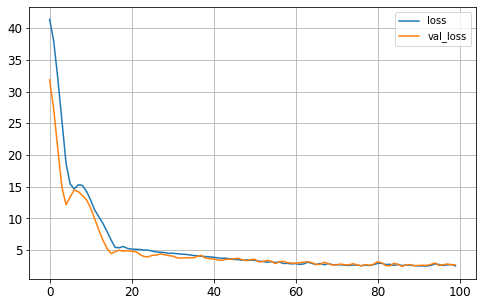

In [54]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

### Draw the mean prediction curve averaged from all quantile predictions.

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


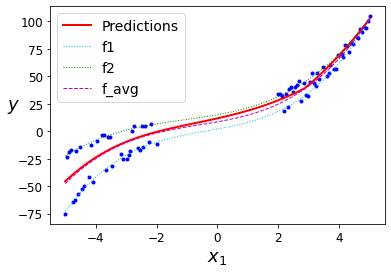

In [55]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
# draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
# draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [56]:
get_prediction_error((lambda X: np.average(model.predict(X), axis=-1) ), func_dict, name="grid-quantileR")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


2.09224290171055

### Draw first and last quantile curve.

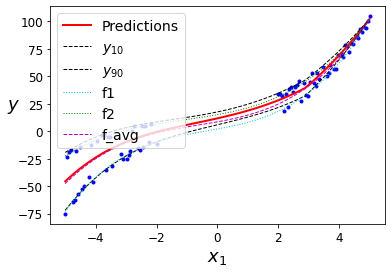

In [57]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

### Draw all quantile predictions

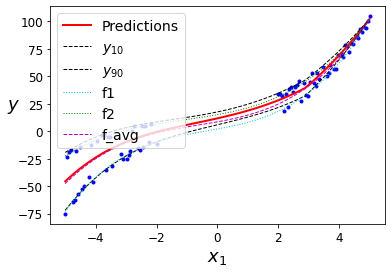

In [58]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
for _idx, _tau in enumerate(quantile_list):
    draw_func((lambda X: model.predict(X)[:,_idx] ), mark='k--', linewidth=1, label="$y_{%d}$" % (_tau*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

## Gaussian Estimation with Gaussian Loss (grid-->parameters)

Gaussain estimation requires the model to predict the mean and variance of a Gaussian distribution of the random variable regarded. The training purpose is to fit a Gaussian distribution to the data distribution (which is not necessay distributed as Gaussian).

One possible solution, derived by BensonHuang, is that the model estimates $(\mu, z)$, where $z=\alpha ^{-1}log(\sigma)$.
The associated loss function can be $L_G(y, (\mu,z)) = 0.5e^{-2\alpha z}(y-\mu)^2 + \alpha z$.

In [59]:
alpha = 1.0
# alpha = 0.01
# alpha = 0.001

In [60]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(2) # (mu, z)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [61]:
# Customized loss function
print("alpha = %f" % alpha)

def GaussianLoss_fn(y_true, y_pred):
    # y_true: label 
    # y_pred: (mu, z), z=log(sigma)
    mu = y_pred[:, 0:1]
    z  = y_pred[:, 1:2]
    #
    en2z = tf.math.exp((-2.0*alpha)*z)
    ymu2 = (y_true - mu)**2
    return (0.5*en2z*ymu2 + alpha*z)

alpha = 1.000000


In [62]:
# Learning rate scheduler
learning_rate_switch_epoch_list = [30, 45]
learning_rate_list = [0.001, 0.01, 0.1]
# learning_rate_switch_epoch_list = [30, 80]
# learning_rate_list = [0.01, 0.1, 0.01]
#
def piecewise_constant_fn(epoch):
    for _i, epoch_s in enumerate(learning_rate_switch_epoch_list):
        if epoch < epoch_s:
            return learning_rate_list[_i]
    return learning_rate_list[-1]

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

Third training with even greater speed

In [63]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss=GaussianLoss_fn, optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [64]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid))

Epoch 1/200
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 2s - loss: 710.1819X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 212ms/step - loss: 294.3063 - val_loss: 6.0177
Epoch 2/200
3/3 [==============================] - 0s 67ms/step - loss: 7.6424 - val_loss: 11.5282
Epoch 3/200
3/3 [==============================] - 0s 95ms/step - loss: 12.7737 - val_loss: 15.6825
Epoch 4/200
3/3 [==============================] - 0s 79ms/step - loss: 16.5455 - val_loss: 18.4986
Epoch 5/200
3/3 [==============================] - 0s 61ms/step - loss: 19.0463 - val_loss: 20.1579
Epoch 6/200
3/3 [==============================] - 0s 73ms/step - loss: 20.4708 - val_loss: 20.8783
Epoch 7/200
3/3 [==============================] - 0s 61ms/step - loss: 21.0357 - val_loss: 20.8755
Epoch 8/200
3/3 [==============================] - 0s 54ms/step - loss: 20.9790 - val_loss

Epoch 81/200
3/3 [==============================] - 0s 67ms/step - loss: 3.2895 - val_loss: 3.2694
Epoch 82/200
3/3 [==============================] - 0s 70ms/step - loss: 3.2746 - val_loss: 3.2594
Epoch 83/200
3/3 [==============================] - ETA: 0s - loss: 3.362 - 0s 95ms/step - loss: 3.2692 - val_loss: 3.2424
Epoch 84/200
3/3 [==============================] - 0s 121ms/step - loss: 3.2655 - val_loss: 3.2343
Epoch 85/200
3/3 [==============================] - 0s 90ms/step - loss: 3.2565 - val_loss: 3.2239
Epoch 86/200
3/3 [==============================] - 0s 120ms/step - loss: 3.2533 - val_loss: 3.2222
Epoch 87/200
3/3 [==============================] - 0s 110ms/step - loss: 3.2742 - val_loss: 3.2518
Epoch 88/200
3/3 [==============================] - 0s 92ms/step - loss: 3.2450 - val_loss: 3.2652
Epoch 89/200
3/3 [==============================] - 0s 83ms/step - loss: 3.2423 - val_loss: 3.2773
Epoch 90/200
3/3 [==============================] - 0s 74ms/step - loss: 3.2458 - 

Epoch 162/200
3/3 [==============================] - 0s 107ms/step - loss: 2.9422 - val_loss: 3.0060
Epoch 163/200
3/3 [==============================] - 0s 107ms/step - loss: 2.9304 - val_loss: 3.0212
Epoch 164/200
3/3 [==============================] - 0s 99ms/step - loss: 3.0166 - val_loss: 3.1228
Epoch 165/200
3/3 [==============================] - 0s 116ms/step - loss: 3.2718 - val_loss: 3.4533
Epoch 166/200
3/3 [==============================] - 0s 67ms/step - loss: 3.2481 - val_loss: 3.4472
Epoch 167/200
3/3 [==============================] - 0s 79ms/step - loss: 3.0946 - val_loss: 3.1567
Epoch 168/200
3/3 [==============================] - 0s 83ms/step - loss: 3.1100 - val_loss: 3.2567
Epoch 169/200
3/3 [==============================] - 0s 61ms/step - loss: 3.1401 - val_loss: 3.1458
Epoch 170/200
3/3 [==============================] - 0s 56ms/step - loss: 3.0123 - val_loss: 3.0882
Epoch 171/200
3/3 [==============================] - 0s 46ms/step - loss: 3.0480 - val_loss: 3.07

In [65]:
# history = model.fit(X_train, y_train, epochs=145,
#                     validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

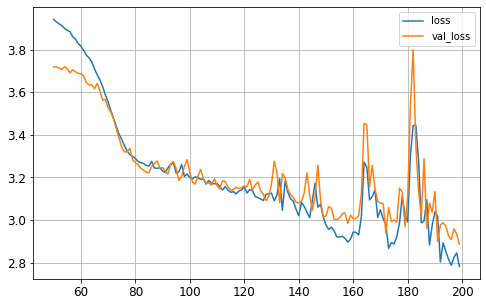

In [66]:
import pandas as pd

# print(history.history)
try:
    lr_list = history.history["lr"]
    del(history.history["lr"])
except:
    pass

pd.DataFrame(history.history)[50:].plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


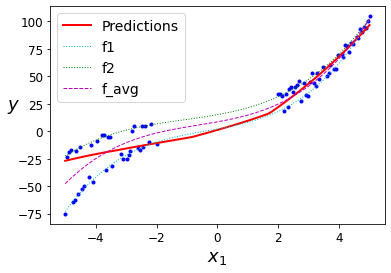

In [67]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

In [68]:
get_prediction_error((lambda X: model.predict(X)[:,0] ), func_dict, name="grid-oneGaussian")

y_func.shape = (100, 1)
y_gt.shape = (100, 1)


5.794580414418331

### Draw the 1-sigma boundary line

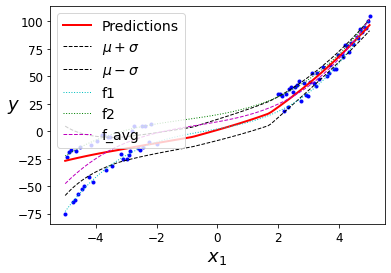

In [69]:
def n_sigma_boundary_line(X, n):
    _y = model.predict(X)
    _mean, _z = _y[:,0:1], _y[:,1:2]
    _sigma = np.exp(alpha*_z)
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Summary

In [70]:
print_all_prediction_error()

num-num: 6.127838
grid-num: 4.337164
grid-rbc: 3.860890
grid-quantileR: 2.092243
grid-oneGaussian: 5.794580
